In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
from keras.optimizers import Adam
from models import build_bi_lstm, train_model_using_cross_val
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

'''
This script is used to train the model for a specific STATE and forecast the cases on a 
specific year (TEST_YEAR). The model is trained  with the regional health data before the year selected. 
'''
STATE = 'MG'
TEST_YEAR = 2023


In [2]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
df.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
date,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False


In [3]:
code_to_state = {33: 'RJ', 32: 'ES', 41: 'PR', 23: 'CE', 21: 'MA',
 31: 'MG', 42: 'SC', 26: 'PE', 25: 'PB', 24: 'RN', 22: 'PI', 27: 'AL',
 28: 'SE', 35: 'SP', 43: 'RS', 15: 'PA', 16: 'AP', 14: 'RR',  11: 'RO',
 13: 'AM', 12: 'AC', 51: 'MT', 50: 'MS', 52: 'GO', 17: 'TO', 53: 'DF',
 29: 'BA'}

In [4]:
df_clima = prep.load_climate_data()

df_clima = df_clima.loc[df_clima.geocode.astype(str).str[:2] == '31']
df_clima.head()

,date,epiweek,geocode,temp_min,temp_med,temp_max,precip_tot,rel_humid_med,temp_amp
2244,2009-12-27,200952,3100104,20.7208,23.4406,27.3525,5.5421,84.8923,6.6317
2245,2009-12-27,200952,3100203,21.2028,24.3718,28.6233,0.8166,79.5011,7.4205
2246,2009-12-27,200952,3100302,20.0611,23.8270,28.7545,0.9051,78.3925,8.6934
2247,2009-12-27,200952,3100401,18.9060,22.3913,27.7191,2.7522,79.8940,8.8131
2248,2009-12-27,200952,3100500,20.1577,24.5404,29.9290,0.5607,75.4242,9.7713


In [5]:
df_end = df.merge(df_clima, left_on = ['date', 'epiweek', 'geocode'], right_on = ['date', 'epiweek', 'geocode'])

df_end.date = pd.to_datetime(df_end.date)

df_end.set_index('date', inplace = True)

df_end.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2,temp_min,temp_med,temp_max,precip_tot,rel_humid_med,temp_amp
date,,,,,,,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False,21.9829,26.5957,32.0409,0.1879,69.7659,10.0580
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False,18.5711,22.3066,27.3997,3.1666,78.2605,8.8286
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False,19.2286,23.4808,28.1682,1.6369,75.2743,8.9396
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False,22.1361,26.4140,31.8807,0.9042,75.2398,9.7446
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False,19.4717,23.8841,28.7656,0.7958,73.9370,9.2939


In [6]:
enso = prep.load_sea_indicators()

enso.head()

,enso,iod,pdo,epiweek_label,epiweek,year
date,,,,,,
2010-01-10,1.230226,-0.419708,-0.115554,201014,14,2010
2010-01-17,1.070318,-0.443917,0.061606,201015,15,2010
2010-01-24,0.957734,-0.154522,0.207900,201016,16,2010
2010-01-31,1.210819,-0.069680,0.385610,201017,17,2010
2010-02-07,1.210819,-0.069680,0.385610,201018,18,2010


In [7]:
# generate the samples to train and test based on the regional data 
columns_to_normalize = ['casos', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot', 'enso', 'iod', 'pdo']

X_train, y_train = prep.generate_regional_train_samples(df_end, enso, TEST_YEAR, columns_to_normalize, True)

In [8]:
X_train.shape

(801, 52, 19)

In [9]:
batch_size = 4

In [10]:
model = build_bi_lstm( hidden=128, loss = 'msle', 
                      features=19, predict_n=52, look_back=52, batch_size = batch_size, optimizer = Adam(learning_rate = 0.001))
model

/opt/homebrew/Caskroom/miniforge/base/envs/train_lstm/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 52, 19)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (4, 52, 128)           │       151,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (4, 52, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 52, 128)           │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 52, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (4, 128)               │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         6,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,428 (1.61 MB)

 Trainable params: 421,428 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [11]:
%%time 
model = train_model_using_cross_val(model, X_train, y_train, n_splits=4, epochs = 5,
                                verbose = 1,
                                batch_size = batch_size, 
                                monitor = 'val_loss',
                                min_delta = 0,
                                patience = 10)

Training fold 1...
Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.0360 - loss: 0.0623 - mape: 42763912.0000 - mse: 0.0835 - val_accuracy: 0.0199 - val_loss: 0.0204 - val_mape: 295754.2188 - val_mse: 0.0231
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.0479 - loss: 0.0146 - mape: 4555230.5000 - mse: 0.0139 - val_accuracy: 0.0597 - val_loss: 0.0157 - val_mape: 3116510.5000 - val_mse: 0.0194
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.0446 - loss: 0.0120 - mape: 5786283.0000 - mse: 0.0126 - val_accuracy: 0.0547 - val_loss: 0.0146 - val_mape: 1559032.8750 - val_mse: 0.0194
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.0445 - loss: 0.0097 - mape: 5112513.5000 - mse: 0.0106 - val_accuracy: 0.0547 - val_loss: 0.0107 - val_mape: 6857114.5000 - val_mse: 0.0143
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.0746 - loss: 0.0084 - mape: 5408953.0000 - mse: 0.0093 - val_accuracy: 0.0846 - val_loss: 0

In [12]:
model.save(f'./saved_models/region_model_{STATE}_{TEST_YEAR}.keras')

In [13]:
from models import sum_regions_predictions

In [14]:
%%time
df_preds = sum_regions_predictions(model, df_end, enso, TEST_YEAR, columns_to_normalize)

df_preds.head()

CPU times: user 27min 23s, sys: 32.5 s, total: 27min 56s
Wall time: 27min 14s


,dates,lower,preds,upper
0,2022-10-09,16.873091,29.862612,190.070551
1,2022-10-16,8.523549,16.830584,62.907979
2,2022-10-23,8.220801,18.103572,124.873967
3,2022-10-30,18.384432,43.004581,199.704449
4,2022-11-06,71.746318,144.703352,490.830158


In [16]:
import matplotlib.pyplot as plt

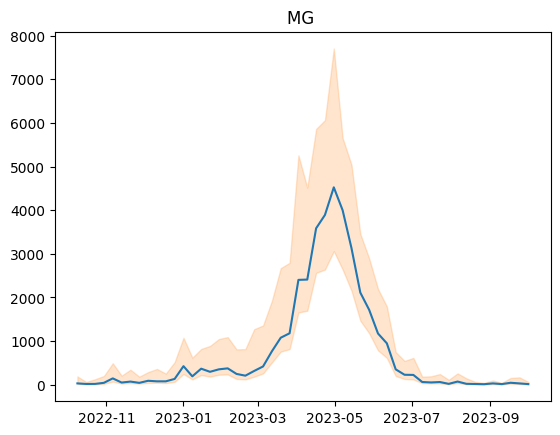

In [17]:
fig, ax = plt.subplots()

#ax.plot(df_w.loc[df_w.year == TEST_YEAR].casos, label = 'Data')

ax.plot(df_preds.dates, df_preds.preds, label = 'preds')

ax.fill_between( df_preds.dates, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG ')

plt.show()